In [1]:
# %load weight_init_activation_histogram.py
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
def box_off():
    ax=plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 초깃값을 다양하게 바꿔가며 실험해보자！
#     w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
#     w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)  # Xavier
#     w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He


    a = np.dot(x, w)


    # 활성화 함수도 바꿔가며 실험해보자！
#     z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

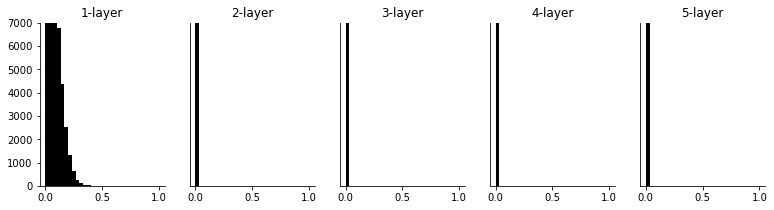

In [3]:
# 히스토그램 그리기
plt.figure(figsize=(13,3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1), color='k')
    box_off()

# plt.show()
plt.savefig('hist.png')

## 6.2.4 MNIST 데이터셋으로 본 가중치 초기값 비교

In [4]:
# %load weight_init_compare.py
import os
import sys

sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0. MNIST 데이터 읽기==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1. 실험용 설정==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2. 훈련 시작==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))



===========iteration:0===========
std=0.01:2.302513390142843
Xavier:2.3049512347896837
He:2.450539178577274
===========iteration:100===========
std=0.01:2.3019992586318474
Xavier:2.247663648790174
He:1.4433279942799127
===========iteration:200===========
std=0.01:2.302569113645954
Xavier:2.165710162552892
He:0.7242854632353859
===========iteration:300===========
std=0.01:2.299352327481507
Xavier:1.9854582445450188
He:0.5115807845386917
===========iteration:400===========
std=0.01:2.3033318424644986
Xavier:1.5988070150577292
He:0.5194606855148122
===========iteration:500===========
std=0.01:2.3016555864925663
Xavier:1.0029428032591843
He:0.4415589563529502
===========iteration:600===========
std=0.01:2.2979706097942465
Xavier:0.6928450183268822
He:0.4069675790117778
===========iteration:700===========
std=0.01:2.295532113833449
Xavier:0.6002244289237284
He:0.3132774772140141
===========iteration:800===========
std=0.01:2.299396019975448
Xavier:0.42636280031579776
He:0.20281656068415232


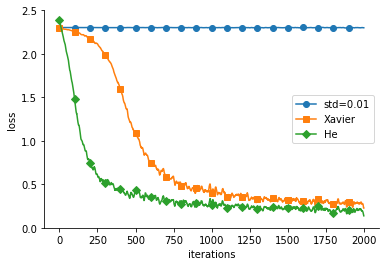

In [5]:


# 3. 그래프 그리기==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
# plt.show()
box_off()